In [1]:
import numpy as np
from scipy.sparse import dia_matrix, diags
from scipy.sparse.linalg import inv
import matplotlib.pyplot as plt
from IPython.display import display, Audio

%matplotlib widget

def ravel_index_from_true_indexes(x_idx, y_idx, Nx) :
    return y_idx*Nx + x_idx

def find_nearest_index(array, value, nearest_value=False):
    """
    # Inputs
    Takes an array and a value as arguments.

    # Ouputs
    Return the index of the nearest value. Also returns (nearest_idx, nearest_value) if nearest_value is True.
    """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if nearest_value :
        return idx, array[idx]
    return idx

In [2]:
model = False
article = True
mode = 'A2'

if model : 
    #medium1
    rho = 677.9661016949153
    Lx = 0.40204081632653066
    Ly = 0.2766326530612245  
    h = 0.00395
    E_nu = 3206458380.6503973
    xinB = np.array([0.088747, 0.030742, 0.112417, 0.052442])#, 0.053975, 0.01313 ,0.042184, 0.06139 , 0.0375])


    ################## plaque : 
    ## Paramètres de discrétisation
    NB = 2          #Nombre de modes selon x
    MB = 2         #Nombre de modes selon y
    NmB = NB * MB      #Nombre de modes total considérés dans le modèle de plaque

    dx = 10e-3 #(10mm)
    dy = 10e-3 #(10mm)
    x = np.arange(0,Lx,dx)
    y = np.arange(0,Ly,dy)
    Nx = len(x)
    Ny = len(y)

    X_plate, Y_plate = np.meshgrid(x, y)
    X_ravel, Y_ravel = np.ravel(X_plate), np.ravel(Y_plate)

    ## Calcul des modes
    def omega_pq (p,q) :    #Calcul analytique des pulsations propres d'une plaque en appuis simple
        return np.sqrt(E_nu*h**2/(12*rho)) * ((p*np.pi/Lx)**2+(q*np.pi/Ly)**2)

    wnB = np.zeros(NmB)
    NmB_idx = np.zeros((2,NmB))   #Cette liste permet de remonter du mode contracté "i" au mode réel (n_i,m_i) en appelant NmB_idx[:,i]
    j = 0
    for n in range(1,NB+1) :
        for m in range(1,MB+1) :
            wnB[j] = omega_pq(n,m)
            NmB_idx[0,j] = n
            NmB_idx[1,j] = m
            j += 1

    ### Tri par ordre de fréquences croissantes
    tri_idx = np.argsort(wnB)

    wnB = wnB[tri_idx]    #On range les pulsations par ordre croissant 
    NmB_idx = NmB_idx[:,tri_idx]      #On ordonne les modes par ordre croissant

    ### Déformées
    def phi_pq (p,q,x,y) :  #Calcul analytique des déformées des modes d'une plaque en appuis simple
        return np.sin(p*np.pi*x/Lx) * np.sin(q*np.pi*y/Ly)

    phiB_NxNy_NmB = np.zeros((Nx*Ny,NmB)) #Matrice des déformées avec les 2 dimensions spatiales applaties en 1 dimension
    for mode in range (NmB) :
        for point in range(Nx*Ny) :
            n = NmB_idx[0,mode]
            m = NmB_idx[1,mode]
            x_ = X_ravel[point]
            y_ = Y_ravel[point]

            phiB_NxNy_NmB[point,mode] = phi_pq(n, m , x_, y_)

    ### Masses modales
    MmB = np.zeros(NmB)
    for j in range(NmB) :
        PHI_j_Ny_Nx = np.reshape(phiB_NxNy_NmB[:,j],(Ny,Nx))      #Correspond à la déformée du mode j sur la plaque (en 2D)
        MmB[j] = rho * h * np.sum(np.sum(PHI_j_Ny_Nx**2,axis=1),axis=0)*dx*dy

    ### Normalisation des modes
    norme_deformee_NmB = np.sqrt(MmB)         #Ref : Modal Testing Theory, Practice and Application p.54, Eq. (2.25)
    phiB_NxNy_NmB = phiB_NxNy_NmB[:,:] / norme_deformee_NmB[np.newaxis,:]

    MB = np.ones(NmB)
    MB_inv = MB 
    CB = 2 * MmB * wnB * xinB
    KB = MmB * wnB ** 2


In [3]:
if article : 
    
    xinB = np.array([2.2,1.1,1.6,1.0,0.7,0.9,1.1,0.7,1.4,0.9,0.7,0.7,0.6,1.4,1.0,1.3])/100
    fnB = np.array([78.3,100.2,187.3, 207.8, 250.9,291.8,314.7,344.5,399.0,429.6,482.9,504.2,553.9,580.3,645.7,723.5])
    MmB = np.array([2.91,0.45,0.09,0.25,2.65,9.88,8.75,8.80,0.90,0.41,0.38,1.07,2.33,1.36,2.02,0.45])
    NmB = len(fnB)

    wnB = 2 * np.pi * fnB
    phiB_NxNy_NmB = np.ones(NmB)
    MB = MmB
    CB = 2*MmB*wnB*xinB
    KB = MmB*wnB**2
    MB_inv = 1 / MmB

In [4]:
################################## cordes
## Paramètres physique

#acier1
#T = 93.947707 
##r = (0.71/2) * 1e-3
#L = 0.65
#rho_c = 7800  #(kg/m3) #de internet /4
#rho_l = rho_c *  (np.pi * r**2) 
#B = 0.0001943572734201584

T = 73.9 
rho_l = (3.61) * 10**(-3)
L = 0.65
#r = 0.40 * 10e-3
B =  4 * 10**(-5)  ##ici c'est le coef B d'inharmonicité de la corde

ct = np.sqrt(T / rho_l) #célérité des ondes transverse (M/s)

## Paramètres de discrétisation
NmS = 150  #Modes de cordes
NnS = np.arange(1,NmS+1)

NxS = 1000 #Discrétisation spatiale
xS = np.linspace(0,L,NxS) #Vecteur de la corde

## Calcul des modes
phiS_Nx_NmS = np.sin((2*NnS[np.newaxis,:]-1)*np.pi*xS[:,np.newaxis] / 2 / L) #Déformées d'une corde fixe/libre
pnS = (2 * NnS - 1) * np.pi / (2 * L)
fnS = (ct / 2 / np.pi) * pnS * (1 + pnS**2 * B / (2 * T)) #Fréquences propres de la corde (hz)

wnS = 2*np.pi*fnS

etaf, etaA, etaB = 7e-5, 0.9, 2.5e-2
xinS = 1/2 * ( T * (etaf + etaA / 2 / np.pi / fnS) + etaB * B * pnS**2 ) / (T + B * pnS**2) #Amortissements modaux de la corde (ø)

MmS = rho_l * L / 2  #Masses modales de la corde (kg)
phiS_Nx_NmS = phiS_Nx_NmS / np.sqrt(MmS)

### Matrices modales
MS = np.ones(NmS) #* MmS
CS = MS * 2 * wnS * xinS
KS = MS * wnS ** 2
MS_inv = np.ones(NmS)# * (1/MmS)


In [5]:
################# bigmatrix :

M_lin = np.concatenate((MS,MB))
C_lin = np.concatenate((CS,CB))
K_lin = np.concatenate((KS,KB))
M_inv_lin = np.concatenate((MS_inv,MB_inv))

M = diags(M_lin)
M_inv = diags(M_inv_lin)
K = diags(K_lin)
C = diags(C_lin)

In [6]:
model = False
article = True
mode = 'A1'

phiSB = phiS_Nx_NmS[-1,:] #déformée de la corde au point du chevalet
phiSF = phiS_Nx_NmS[1,:] #déformée de la corde au point d'appuis du doigt du guitariste


In [7]:
if model : 
    Nx = len(x)
    Ny = len(y)
    #Point de couplage (par rapport à la table)
    xc, yc = x[int(24.5/40*Nx)], y[int(10/26 * Ny)]
    xc_idx, yc_idx = find_nearest_index(x, xc), find_nearest_index(y, yc)
    xyc = ravel_index_from_true_indexes(xc_idx, yc_idx, Nx)
    #print(xyc)
    #pour modèle de la plaque:
    phiBS = phiB_NxNy_NmB[xyc,:]

if article : 
    phiBS = phiB_NxNy_NmB
    xyc = 0


In [8]:
if mode == 'A1':
    Aa = np.block([
                    [phiSB.T, np.zeros(NmB)],
                    [phiSF.T, np.zeros(NmB)]
    ])
if mode == 'A2':
    Aa = np.block([
                    [phiSB.T, - phiBS],
                    [phiSF.T, np.zeros(NmB)]
    ])


M_inv_demi = M_inv.sqrt()

B = Aa @ M_inv_demi
Bplus = B.T @ np.linalg.inv((B @ B.T))
W = np.eye(NmS+NmB) - M_inv_demi @ Bplus @ Aa

Z = - M.sqrt() @ Bplus @ Aa #pour calculer la force ensuite

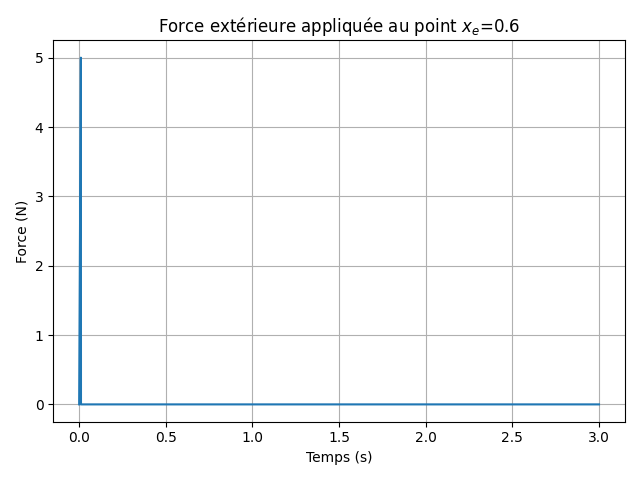

In [20]:
Fe = 100000
T = 3
t = np.linspace(0, T, T*Fe) #Vecteur temps
Nt = len(t)
L = 0.65 #a changer dans la def de corde si on change

# Force extérieure appliquée à la corde
Fext = np.zeros_like(t)

fm = 5
#t1 = int(4*0.016*Fe) #indice du temps où l'on lâche la corde
#t2 = t1 + int(0.5*1e-3*Fe) #indice du temps où la force repasse à 0 (fin du glissement du plectre sur la corde) : à modéliser, int(1/2*1e-3*Fe) pour le moment #CF thèse Grégoire Derveaux, eq. 1.34
t1 = int(0.01 * Fe)
Fext[:t1] = np.linspace(0,1,t1) * fm
#Fext[:t1] = fm/2 * (1 - np.cos(np.pi*t[:t1]/t[t1]))
#Fext[t1:t2] = fm/2 * (1 + np.cos(np.pi*(t[t1:t2]-t[t1])/(t[t2]-t[t1])))

#Fext[idx_fin:idx_zero] = np.linspace(1,0,idx_zero - idx_fin) * 0.187 #Dans ce cas, Fext est une rampe
xe_idx = find_nearest_index(xS, 0.9*L)
NxS = len(xS)

FextS_NxS_Nt = np.zeros((NxS,Nt))
FextS_NxS_Nt[xe_idx, : ] = Fext

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(t,Fext,label="")
ax1.grid()
#ax1.legend()
ax1.set_xlabel("Temps (s)")
ax1.set_ylabel("Force (N)")
ax1.set_title(rf"Force extérieure appliquée au point $x_e$={xS[xe_idx]:.1f}")

fig.tight_layout()

plt.show()

In [21]:
F_pro_cor = phiS_Nx_NmS.T @ FextS_NxS_Nt # projection de la force
point_temp = len(t)
#print(NmS,NmB,point_temp,FextS_NxS_Nt.shape)
#comme il n'y a pas de force extérieur sur la table, leur projection sur la base modale vaut 0

F_pro_tot = np.zeros((NmS+NmB,point_temp)) 
F_pro_tot[:NmS,:] = F_pro_cor

#initialisation du shéma numérique de résolution
q_temp = np.zeros((NmS + NmB, point_temp))
q_dd_temp = np.zeros((NmS + NmB, point_temp))
q_d_temp = np.zeros(NmS + NmB)
q_d_temp_demi = np.zeros_like(q_d_temp)
q_pour_f = np.zeros_like(q_temp)

#shéma
h = t[1] - t[0] #step d'intégration

for i in range(point_temp - 1):

    q_temp[:,i+1] = q_temp[:,i] + h * q_d_temp + 0.5 * h**2 * q_dd_temp[:,i]
    q_d_temp_demi = q_d_temp + 0.5 * h * q_dd_temp[:,i]
    F_temp = - C.dot(q_d_temp_demi) - K.dot(q_temp[:,i+1]) + F_pro_tot[:,i+1]
    q_pour_f[:,i+1] = M_inv.dot(F_temp)

    q_dd_temp[:,i+1] = W @  q_pour_f[:,i+1]

    q_d_temp = q_d_temp + 0.5 * h * (q_dd_temp[:,i] + q_dd_temp[:,i+1])

Q = q_dd_temp
Q_pos = q_temp

F_c = Z @ q_pour_f


In [22]:
FS = F_c[:NmS,:]
F = phiS_Nx_NmS[-1,:] @ FS
F_f = np.fft.rfft(F)
freq = np.fft.rfftfreq(len(F)) * Fe

In [23]:
display(Audio(F,rate=Fe))  ## article

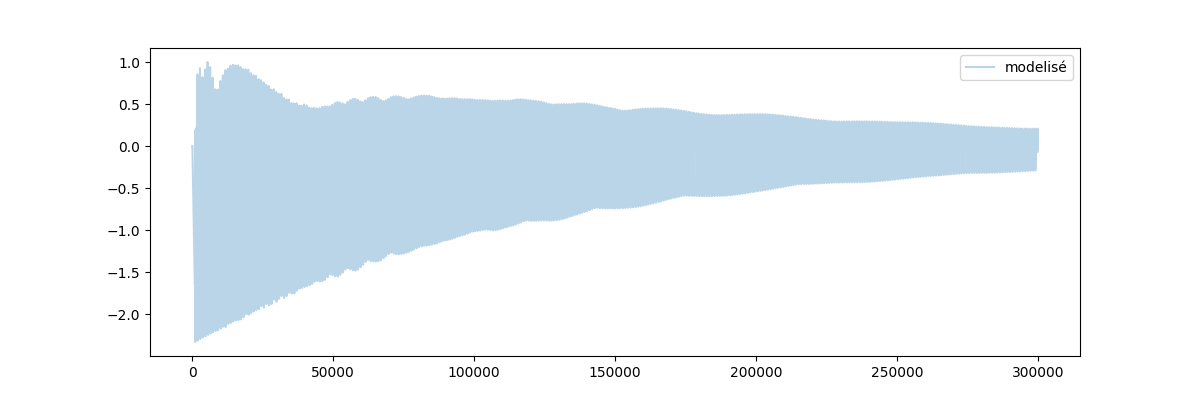

In [24]:
plt.figure(figsize=(12,4))
#plt.plot(acc/max(acc),label='mesure')
plt.plot(F/max(F),label='modelisé',alpha = 0.3)
plt.legend()
plt.show()

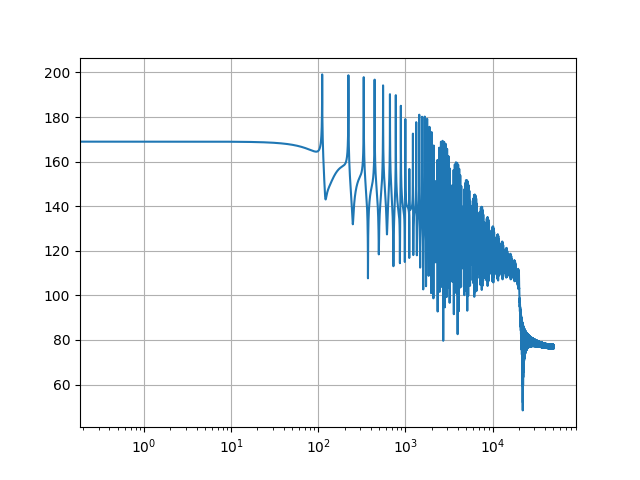

In [26]:
plt.figure()
plt.semilogx(freq,20*np.log10(np.abs(F_f)),label='Force_corde')
plt.grid()
plt.show()